## Domains shared by congressional Republicans

**Purpose**: which media outlets resonate directly and indirectly with congressional Republicans over the 2016-2020 period?

**Steps (TODO)**:



In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from pprint import pprint
import datetime

%matplotlib inline
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format

In [2]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '01-shared-domains', logger_type='main')

In [3]:
import urlexpander

In [4]:
from usrightmedia.shared.clusters_utils import extract_dyads

2021-12-10 23:20:02,190 - [WARNING] - INCA - (hype_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?
2021-12-10 23:20:02,194 - [WARNING] - INCA - (var_tsa_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?


In [5]:
from inca import Inca
myinca = Inca()

## 1.0 Merge the data

### 1.1 Check that each outlet's netloc values are included in `media_references.py`

In [6]:
outlet_doctypes = [
    "americanrenaissance",
    "breitbart",
    "dailycaller",
    "dailystormer",
    "foxnews",
    "gatewaypundit",
    "infowars",
    "newsmax",
    "oneamericanews",
    "rushlimbaugh",
    "seanhannity",
    "vdare",
    "washingtonexaminer",
]

In [7]:
def check_netlocs(outlet_doctypes):
    dfs = []
    for doctype in outlet_doctypes:
        doctype_urls = [doc["_source"]["resolved_url"] for doc in myinca.database.doctype_generator(doctype)]
        df = pd.DataFrame(doctype_urls).rename(columns={0:"resolved_url"})
        df["standardized_netloc"] = df["resolved_url"].map(lambda x: urlexpander.url_utils.standardize_url(x,
                                                                                                          remove_scheme=True,
                                                                                                          replace_netloc_with_domain=False,
                                                                                                          remove_path=True,
                                                                                                          remove_query=True,
                                                                                                          remove_fragment=True,
                                                                                                          to_lowercase=True))
        df["url_netloc"] = df["standardized_netloc"].str.replace('www.', '', regex=False) # align field format before merging outlet-level dataframe with doc-level dataframe
        df["doctype"] = doctype
        dfs.append(df)
    df_all_doctypes = pd.concat(dfs)
    return df_all_doctypes

In [8]:
df_doctype_urls = check_netlocs(outlet_doctypes)
df_doctype_urls.groupby(["doctype", "url_netloc"]).size()

100%|██████████| 20793/20793 [00:06<00:00, 3017.12it/s]


doctype              url_netloc                 
americanrenaissance                                    29
                     amren.com                       2255
breitbart                                             112
                     breitbart.com                  39277
                     breitbart.com:80                  23
dailycaller                                            46
                     amp.dailycaller.com               85
                     checkyourfact.com                207
                     dailycaller.com                28263
                     dailycaller.com:80                44
                     smokeroom.com                    818
dailystormer                                           22
                     dailystormer.com                 504
                     dailystormer.com:80             2000
                     dailystormer.name                  4
                     dailystormer.su                 1475
foxnews                

### 1.2 Merge dataframes related to outlets' URL domain names and ideological category

In [9]:
from usrightmedia.shared.media_references import get_media_outlet_ideo, get_media_outlet_netloc

df_ideo = get_media_outlet_ideo()
df_netloc = get_media_outlet_netloc(include_national = True,
                                    include_regional = False,
                                    include_gop = False,
                                    include_government = False)

In [10]:
df_outlets = df_netloc.merge(right=df_ideo, how="left", on="outlet_std")
# keep outlets which are assigned an ideo category
df_outlets = df_outlets.loc[df_outlets["ideo_category"].notna()].reset_index(drop=True)
df_outlets = df_outlets[["outlet", "outlet_std", "url_netloc", "is_selected_outlet", "pew_libdem", "pew_consrep", "pew_libdem_consrep_diff", "ideo_category", "ideo_subcategory", "ideo_left2right"]]
df_outlets

,outlet,outlet_std,url_netloc,is_selected_outlet,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,ABC News,abcnews,abcnews.go.com,False,22.0,21.0,1.0,mixed,mixed,21.0
1,ABC News,abcnews,abcn.ws,False,22.0,21.0,1.0,mixed,mixed,21.0
2,American Renaissance,americanrenaissance,amren.com,True,NaN,NaN,-999.0,right,alternative right,34.0
3,BBC,bbc,bbc.com,False,42.0,14.0,28.0,left,left,8.0
4,Business Insider,businessinsider,businessinsider.com,False,40.0,20.0,20.0,left,left,16.0
...,...,...,...,...,...,...,...,...,...,...
71,Washington Examiner,washingtonexaminer,washingtonexaminer.com,True,14.0,44.0,-29.0,right,established right,24.0
72,Washington Examiner,washingtonexaminer,m.washingtonexaminer.com,True,14.0,44.0,-29.0,right,established right,24.0
73,Washington Examiner,washingtonexaminer,washex.am,True,14.0,44.0,-29.0,right,established right,24.0
74,Washington Post,washingtonpost,washingtonpost.com,False,45.0,12.0,33.0,left,left,7.0


### 1.3 Make dataframe of URLs which were (re-)tweeted by congressional Republicans

In [11]:
docs = [doc for doc in myinca.database.doctype_generator("tweets2_url")]
docs = [{key: doc["_source"][key] for key in ["url_id", "created_at", "username", "standardized_url", "standardized_netloc", "standardized_domain", "standardized_url_is_generic", "urlexpander_error"]} for doc in docs]
df_docs = pd.DataFrame(docs)
df_docs["created_at"] = pd.to_datetime(df_docs["created_at"], unit="ms")
df_docs["created_at_year"] = df_docs["created_at"].map(lambda d: datetime.datetime(year=d.year, month=1, day=1))
df_docs

100%|██████████| 285447/285447 [00:47<00:00, 6004.44it/s] 


,url_id,created_at,username,standardized_url,standardized_netloc,standardized_domain,standardized_url_is_generic,urlexpander_error,created_at_year
0,748873982749904896_0,2016-07-01 13:40:45,RepNewhouse,www.yakimaherald.com/news/state_news/rep-newho...,www.yakimaherald.com,yakimaherald.com,False,no error,2016-01-01
1,1042878587458777088_0,2018-09-20 20:50:05,RepDanDonovan,bit.ly/2qmqjek,bit.ly,bit.ly,False,CONNECTIONPOOL_ERROR,2018-01-01
2,1275534789861347329_0,2020-06-23 21:02:46,RepCarolMiller,miller.house.gov/media/press-releases/congress...,miller.house.gov,house.gov,False,no error,2020-01-01
3,745681260324986883_0,2016-06-22 18:14:01,RepNewhouse,speaker.gov/live,speaker.gov,speaker.gov,False,CLIENT_ERROR,2016-01-01
4,941360575854075905_0,2017-12-14 17:33:45,RepDanDonovan,www.washingtonexaminer.com/new-york-congressma...,www.washingtonexaminer.com,washingtonexaminer.com,False,no error,2017-01-01
...,...,...,...,...,...,...,...,...,...
285442,709773475796410368_0,2016-03-15 16:09:18,RepSanfordSC,1.usa.gov/1lob5ke,1.usa.gov,usa.gov,False,CLIENT_ERROR,2016-01-01
285443,707941418279505920_0,2016-03-10 14:49:21,RepSanfordSC,roll.cl/1lrbh0g,roll.cl,roll.cl,False,no error,2016-01-01
285444,1181955386817036288_0,2019-10-09 15:31:38,AustinScottGA08,newswire.caes.uga.edu/story/8115/ag-hall-of-fa...,newswire.caes.uga.edu,uga.edu,False,no error,2019-01-01
285445,1301239695968436229_0,2020-09-02 19:24:54,RepBradWenstrup,thehill.com/blogs/congress-blog/healthcare/514...,thehill.com,thehill.com,False,no error,2020-01-01


### 1.4 Merge the outlet-level dataframe and (re-)tweeted URL dataframe based on URL netloc
- each row is a URL along with its associated outlet's ideo info

In [12]:
df_docs = df_docs.loc[~df_docs["standardized_url_is_generic"]].reset_index(drop=False)

# this step is a filter for URLs from selected outlets (i.e., right-wing media outlets)
# trim away "www." and ":80" since those differences are irrelevant for merging
df_docs["url_netloc"] = df_docs["standardized_netloc"].str.replace('www.', '', regex=False).str.replace(':80', '', regex=False)
df_urls = df_docs.merge(right=df_outlets, how="inner", on="url_netloc")
df_urls=df_urls[["url_id", "created_at", "created_at_year", "username",
                 "standardized_url", "url_netloc", "urlexpander_error",
                 "outlet", "outlet_std", "is_selected_outlet",
                 "pew_libdem", "pew_consrep", "pew_libdem_consrep_diff",
                 "ideo_category", "ideo_subcategory", "ideo_left2right"]]
len(df_urls)

36019

- all URLs

In [13]:
# check merge; shows how many URLs are from recognized outlets (including non-right-wing media)
len(df_docs.loc[df_docs["url_netloc"].isin(df_outlets["url_netloc"])])

36019

In [14]:
# number of URLs which are selected right-wing media outlets
df_urls.groupby("is_selected_outlet").size()

is_selected_outlet
False    22058
True     13961
dtype: int64

- unique URLs

In [15]:
df_urls["standardized_url"].nunique()

26744

In [16]:
df_urls.drop_duplicates(subset=["standardized_url"], keep="first").groupby("is_selected_outlet").size()

is_selected_outlet
False    17063
True      9681
dtype: int64

In [17]:
def check_url(url_to_match):
    search_param = {
                    "_source": ["_id", "standardized_url"],
                    "size": 10000,
                    "query": {
                        "bool": {
                            "filter": [
                                {"terms": {
                                            "doctype": [
                                              "americanrenaissance",
                                              "breitbart",
                                              "dailycaller",
                                              "dailystormer",
                                              "foxnews",
                                              "gatewaypundit",
                                              "infowars",
                                              "newsmax",
                                              "oneamericanews",
                                              "rushlimbaugh",
                                              "seanhannity",
                                              "vdare",
                                              "washingtonexaminer"
                                            ]
                                          }},
                                {"term": {"standardized_url.keyword": url_to_match}},
                                {"term": {"should_include": True}}, # percent of unique Media Cloud URLs from selected outlets which were (re-)tweeted by 1+ politician: 25% without this criterion, 17% with this criterion
                            ]
                        }
                    },
                }

    res = myinca.database._client.search(index=myinca.database._elastic_index, body=search_param)
    hits = res["hits"]["hits"]
    matched_ids = [d["_id"] for d in hits]
    
    
    return matched_ids

In [18]:
%%time
# check: percent of unique Media Cloud URLs from selected outlets which were (re-)tweeted by 1+ politician
tw_mc_match = {}
for n, url in enumerate(df_urls.loc[df_urls["is_selected_outlet"]]["standardized_url"]):
    checked = check_url(url)
    if len(checked) > 0:
        tw_mc_match[f"url_{n}"] = {"url": url,
                                    "doc_ids": checked}
        
num_matches = len(tw_mc_match.keys())
uniq_mc_urls = df_urls.loc[df_urls["is_selected_outlet"]]["standardized_url"].nunique()

print(f"{num_matches} (re-)tweeted URLs matched into Media Cloud URLs")
print(f"{uniq_mc_urls} unique Media Cloud URLs")
print(f"{round((num_matches/uniq_mc_urls)*100,2)}% of unique Media Cloud URLs from selected outlets which were (re-)tweeted by 1+ politician")

1654 (re-)tweeted URLs matched into Media Cloud URLs
9681 unique Media Cloud URLs
17.09% of unique Media Cloud URLs from selected outlets which were (re-)tweeted by 1+ politician
CPU times: user 11.9 s, sys: 1.28 s, total: 13.1 s
Wall time: 55.7 s


In [20]:
tw_mc_match["url_26"]

{'url': 'www.washingtonexaminer.com/boom-40-companies-give-trump-tax-reform-bonuses-up-to-2-000',
 'doc_ids': ['WashingtonExaminer_798426078']}

### 1.5 Find which (re-)tweeted URLs are matched to multi-article news events (used for tracing indirect political resonance)
- As shown in the example below, each item in a dyad has a `doc_tw` key which lists whether the particular article was directly (re-)tweeted 1+ times.
- We can then use the dyads to figure out if the outlet associated with the directly (re-)tweeted URL was the "leader" in covering this news event or if it was a "follower".

In [21]:
dyads_dir = os.path.join("..", "..", "data", "02-intermediate", "06-newsevents", "06-softcosine-dyads")
threshold = "softcos06"

In [22]:
with open(os.path.join(dyads_dir, f'{threshold}_dyads_cx_filtered_IPR.pkl'), 'rb') as file:
      dyads_cx_filtered_IPR = pickle.load(file)
    
dyads_filtered_IPR = extract_dyads(dyads_cx_filtered_IPR)

In [ ]:
# [d1 for d0, d1 in dyads_cx_filtered_IPR["softcos06_1000"]]

In [ ]:
# example
# dyads_cx_filtered_IPR["softcos06_10032"]

In [23]:
tweeted_docs = []
for dyad in dyads_filtered_IPR:
    for item in dyad:
        if len(item["doc_tw"]) > 0:
            tweeted_docs.append(item)
            
# drop_duplicates: The first item (document) within each dyad is identical to the other dyads within the same cluster. Keep the first instance only.
# explode: The doc_tw column contains a list of tweets2_url IDs. 'Explode' the dataframe so that each row corresponds with a (re-)tweeted URL. The values of the other columns are duplicated.
df_tweeted = pd.DataFrame(tweeted_docs)\
               .drop_duplicates(subset=["cluster_id","doc_id"], keep="first")\
               .explode("doc_tw")\
               .reset_index(drop=True)\
               .rename(columns={"doc_tw": "url_id"})
print(f"{len(df_tweeted)} (re-)tweeted URLs are part of multi-article news events.")
df_tweeted

399 (re-)tweeted URLs are part of multi-article news events.


,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic,url_id
0,softcos06_10032,2,FoxNews_1540214661,2020-03-06 06:29:23+00:00,"MSNBC’s Brian Williams, NY Times editor marvel...",foxnews,est,topic2,jasoninthehouse_1235996853180731392_0
1,softcos06_10127,2,FoxNews_1224824066,2019-03-15 18:53:28+00:00,Young Beto O'Rourke wrote 'murder fantasy' abo...,foxnews,est,topic2,jasoninthehouse_1106659286862708736_0
2,softcos06_1028,6,FoxNews_1538795747,2020-03-04 22:03:05+00:00,House easily passes $8.3B spending bill to bat...,foxnews,est,topic2,RepArmstrongND_1235334929686376454_0
3,softcos06_103,22,FoxNews_769152934,2018-01-12 17:53:00+00:00,War of words escalates over Trump's immigratio...,foxnews,est,topic1,RepMullin_951909166624444416_0
4,softcos06_104,22,FoxNews_1486791860,2020-01-05 07:23:56+00:00,AOC calls Trump 'a monster' over threat to Ira...,foxnews,est,topic1,RepMarkGreen_1214226071262056452_0
...,...,...,...,...,...,...,...,...,...
394,softcos06_962,7,FoxNews_789727843,2018-02-05 16:19:00+00:00,"Edwin Jackson, Indianapolis Colts linebacker, ...",foxnews,est,topic2,ToddRokita_960599363050491904_0
395,softcos06_978,6,Breitbart_421891282,2016-02-04 19:00:45+00:00,Official: Border Patrol Only Able to Arrest 40...,breitbart,alt,topic3,jasoninthehouse_695665131938803717_0
396,softcos06_996,6,FoxNews_1522699028,2020-02-16 18:11:26+00:00,NYC subway thief thanks Democrats after his 13...,foxnews,est,topic2,jasoninthehouse_1229206558552227852_0
397,softcos06_996,6,FoxNews_1522699028,2020-02-16 18:11:26+00:00,NYC subway thief thanks Democrats after his 13...,foxnews,est,topic2,RepGregMurphy_1229178812908425216_0


In [24]:
df_tweeted.groupby("doctype").size()

doctype
breitbart              33
dailycaller            46
foxnews               289
washingtonexaminer     31
dtype: int64

- prepare for merge by aligning `url_id`

In [31]:
df_urls["url_id"] = df_urls["username"] + "_" + df_urls["url_id"]
df_urls["url_id"]

0         RepDanDonovan_RepDanDonovan_941360575854075905_0
1         RepMarkWalker_RepMarkWalker_984443727098806272_0
2             RepJimBanks_RepJimBanks_839116099803316225_0
3             RepJimBanks_RepJimBanks_830112545168035841_0
4              SenTedCruz_SenTedCruz_1240797814621339650_0
                               ...                        
36014    WarrenDavidson_WarrenDavidson_9552689726052106...
36015    cathymcmorris_cathymcmorris_1012081888045948934_0
36016        RepDonBacon_RepDonBacon_1026102374484647936_0
36017           JerryMoran_JerryMoran_822061761167769600_0
36018     cathymcmorris_cathymcmorris_973006941441134594_0
Name: url_id, Length: 36019, dtype: object

#### 1.5 Merge the (re-)tweeted URL dataframe with the dyadic info

In [36]:
df_urls_inner = df_urls.merge(right=df_tweeted, how="inner", on="url_id")
df_urls_all = df_urls.merge(right=df_tweeted, how="left", on="url_id")

In [32]:
with pd.option_context("display.max_colwidth", None):
    display(df_urls_left)

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,ideo_subcategory,ideo_left2right,cluster_id,cluster_size,doc_id,doc_publish_date,doc_title,doctype,doctype_ideo,doc_topic
0,RepDanDonovan_941360575854075905_0,2017-12-14 17:33:45,2017-01-01,RepDanDonovan,www.washingtonexaminer.com/new-york-congressmans-creeper-act-would-ban-sales-of-child-sex-dolls-in-us,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,established right,24.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,RepMarkWalker_984443727098806272_0,2018-04-12 14:50:49,2018-01-01,RepMarkWalker,www.washingtonexaminer.com/tag/donald-trump,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,established right,24.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,RepJimBanks_839116099803316225_0,2017-03-07 14:10:42,2017-01-01,RepJimBanks,www.washingtonexaminer.com/tag/donald-trump,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,established right,24.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,RepJimBanks_830112545168035841_0,2017-02-10 17:53:48,2017-01-01,RepJimBanks,www.washingtonexaminer.com/tag/barack-obama,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,established right,24.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,SenTedCruz_1240797814621339650_0,2020-03-20 00:30:26,2020-01-01,SenTedCruz,www.washingtonexaminer.com/news/surgeon-general-urges-young-people-to-donate-blood-to-help-hospitals-during-coronavirus-pandemic,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,established right,24.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36014,WarrenDavidson_955268972605210624_0,2018-01-22 02:40:45,2018-01-01,WarrenDavidson,amp.dailycaller.com/2018/01/21/fbi-failed-preserve-anti-trump-texts,amp.dailycaller.com,no error,Daily Caller,dailycaller,True,...,established right,26.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
36015,cathymcmorris_1012081888045948934_0,2018-06-27 21:15:00,2018-01-01,cathymcmorris,checkyourfact.com/2018/06/27/fact-check-wages-fastest-2008,checkyourfact.com,no error,Daily Caller,dailycaller,True,...,established right,26.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
36016,RepDonBacon_1026102374484647936_0,2018-08-05 13:47:24,2018-01-01,RepDonBacon,checkyourfact.com/2018/08/04/fact-check-barletta-job-openings-unemployed,checkyourfact.com,no error,Daily Caller,dailycaller,True,...,established right,26.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
36017,JerryMoran_822061761167769600_0,2017-01-19 12:42:51,2017-01-01,JerryMoran,www.npr.org/player/embed/510533984/510533985,npr.org,no error,NPR,npr,False,...,left,5.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


## 2.0 Yearly counts

In [37]:
# dataframe which counts the number of (re-)tweeted URLs per outlet by year
df_counts = df_urls.groupby([lambda d: df_urls_all["created_at"][d].year, "outlet"],  dropna=False)\
                   .count()[["url_id"]]\
                   .reset_index()\
                   .rename(columns={"level_0":"year", "url_id":"count"})\
                   .merge(right=df_ideo, how="left", on="outlet")

with pd.option_context("display.max_rows", None):
    display(df_counts.head())

,year,outlet,count,outlet_std,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,2016,ABC News,167,abcnews,22.0,21.0,1,mixed,mixed,21
1,2016,BBC,23,bbc,42.0,14.0,28,left,left,8
2,2016,Breitbart,136,breitbart,1.0,80.0,-79,right,alternative right,27
3,2016,Business Insider,22,businessinsider,40.0,20.0,20,left,left,16
4,2016,BuzzFeed,16,buzzfeed,40.0,17.0,23,left,left,11


## 3. Plots

In [35]:
%matplotlib inline

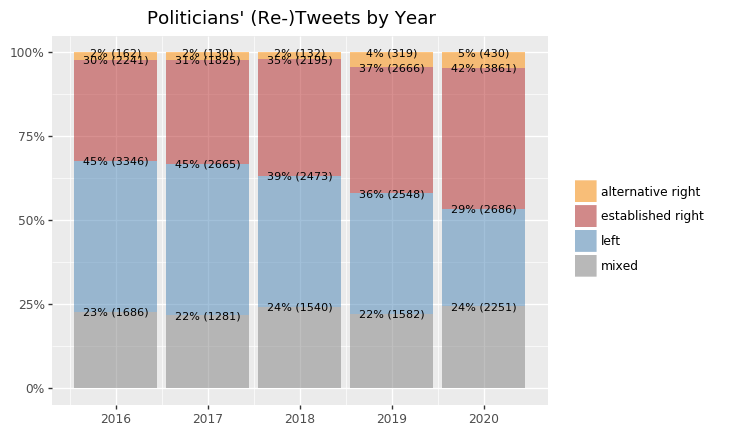

<ggplot: (8727754859801)>

In [38]:
def count2pct_subcat(counts):
    md_count = np.asarray(counts).reshape((4,5)) # multi-dim array with 4 rows (left/mixed/est-right/alt-right) and 5 columns (2016-2020)
    md_pct = md_count/md_count.sum(axis=0) # calculate percent of each cell by column
    sd_pct = md_pct.flatten() # plotnine requires a 1D array
    fmt = [f'{p*100:.0f}% ({counts[n]})' for n, p in enumerate(sd_pct)] # format the presentation of the 1D array
    return fmt

plt_ideo_subcat_pct = (p9.ggplot(df_urls_all,
                       p9.aes(x='created_at_year')) +
                         p9.geom_bar(p9.aes(fill='ideo_subcategory'), position='fill', alpha=0.5) +
                         p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey']) +
                         p9.geom_text(p9.aes(label='stat(count2pct_subcat(count))',group='ideo_subcategory'),
                                   position='fill',
                                   stat='count',
                                   va='center',
                                   size=8) + 
                         p9.scale_y_continuous(labels=percent_format()) + 
                         p9.scale_x_datetime(labels=date_format("%Y")) +
                         p9.labs(title="Politicians' (Re-)Tweets by Year",
                              fill='',
                              x='',
                              y=''))

display(plt_ideo_subcat_pct)

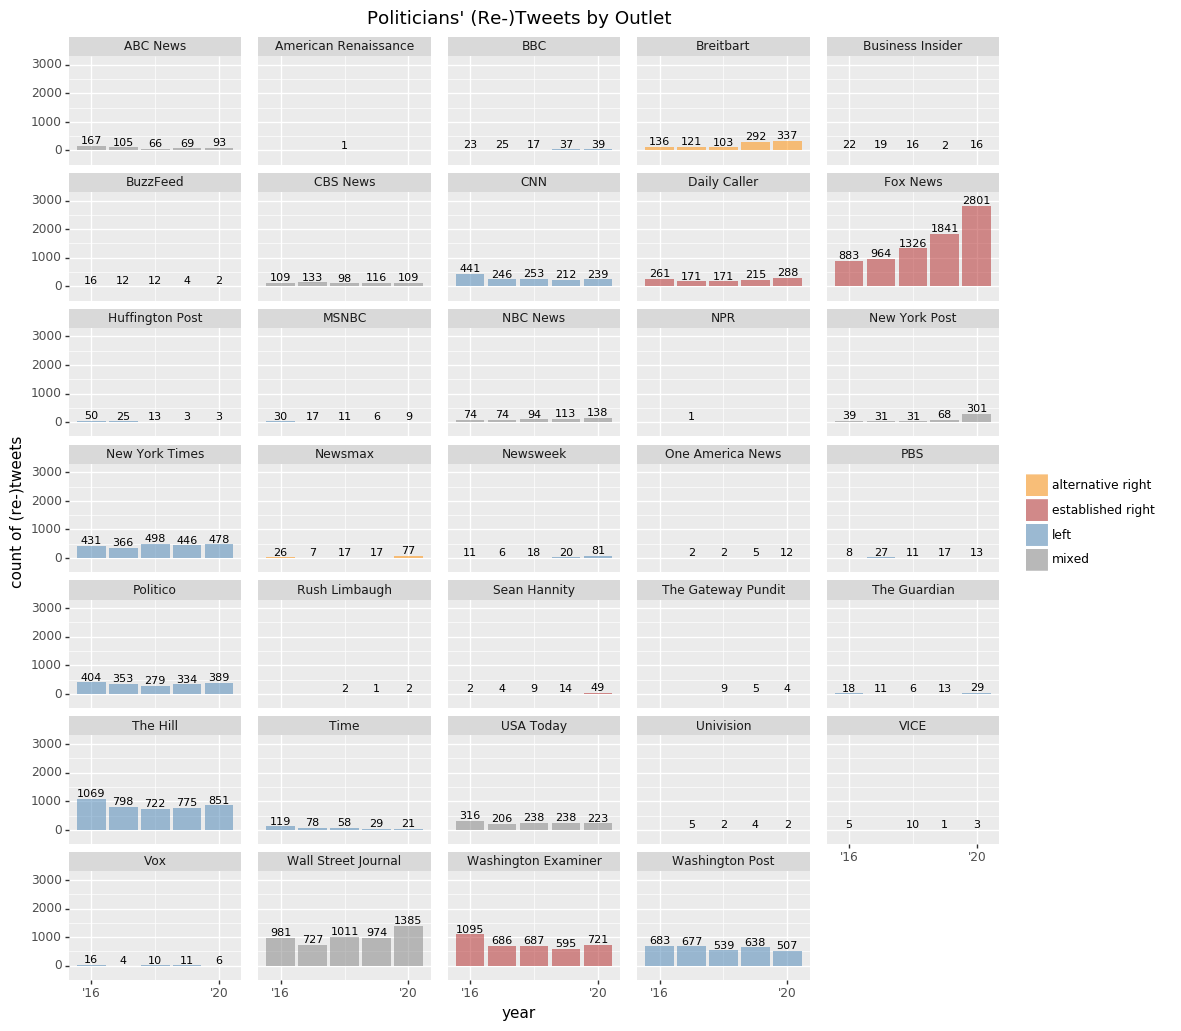

<ggplot: (8727744308743)>

In [39]:
plt_outlet = (p9.ggplot(data=df_urls_all,
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_bar(p9.aes(fill='ideo_subcategory'), stat='count',
                            alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.facet_wrap("outlet", labeller='label_value', ncol=5)
                 + p9.theme(figure_size=(12, 12),
                     subplots_adjust={'wspace': 0.10,
                                      'hspace': 0.25
                                     })
                 + p9.labs(title="Politicians' (Re-)Tweets by Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet)

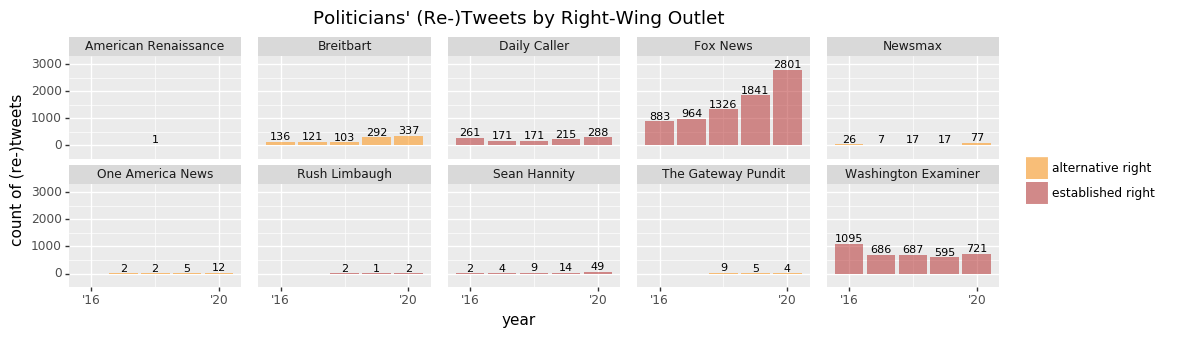

<ggplot: (8727739451230)>

In [40]:
plt_outlet_right = (p9.ggplot(
                    data=df_urls_all.loc[df_urls_all["ideo_category"]=="right"], 
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_bar(p9.aes(fill='ideo_subcategory'), stat='count', alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.facet_wrap('outlet', labeller='label_value', ncol=5)
                 + p9.theme(figure_size=(12, 3),
                         subplots_adjust={'wspace': 0.10,
                                          'hspace': 0.25
                                         }
                        )
                 + p9.labs(title="Politicians' (Re-)Tweets by Right-Wing Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet_right)

In [ ]:
# average tweets per politician